# Validation of template errors search using manually found issues

## Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set path to following csv files

auto_filepath = ''
manual_filepath = ''

In [3]:
# Setting parameters

ignore_issues = []
ignore_frequency = 0.05

In [4]:
df_auto = pd.read_csv(auto_filepath)
df_manual = pd.read_csv(manual_filepath)

# Filtering manual dataset

df_manual = df_manual[df_manual['Type'] == 'template']
df_manual['Issue'] = df_manual['Issue.1']
df_manual['Line'] = df_manual['Template\r\nCode\r\nLine']
df_manual = df_manual[['Step id', 'Issue', 'Line', '%']]
df_manual.rename(columns={
    'Step id': 'step_id', 
    'Issue': 'origin_class', 
    'Line': 'pos_in_template', 
    '%': 'frequency',
}, inplace=True)

# Filtering auto dataset

df_auto = df_auto[df_auto['step_id'].isin(df_manual['step_id'].unique())]
df_auto['pos_in_template'] = df_auto['pos_in_template'].map(lambda x: x + 1)

# Dropping out invalid issues

df_auto = df_auto[~df_auto['origin_class'].isin(ignore_issues)]
df_manual = df_manual[~df_manual['origin_class'].isin(ignore_issues)]

df_auto = df_auto[df_auto['frequency'] > ignore_frequency]
df_manual = df_manual[df_manual['frequency'] > ignore_frequency]

df_auto = df_auto[~df_auto['pos_in_template'].isna()]
df_manual = df_manual[~df_manual['pos_in_template'].isna()]

In [5]:
def parse_pos_in_template(x: str):
    """
    Interpret sequence entries like '57-59', '89,91', '-', etc.
    Examples:
    '57-59' -> [57, 58, 59]
    '89,91' -> [89, 91]
    '31'    -> [31]
    '-'     -> []
    """
    
    if x == 'nan' or x == '-':
        return []
    positions = [s.strip() for s in x.split(',')]
    res = []
    for pos in positions:
        s = pos.split('-')
        if len(s) > 1:
            res += list(range(int(s[0]), int(s[1]) + 1))
        else:
            res.append(int(s[0]))
    return res


def get_unique_pairs(df: pd.DataFrame, first_col: str, second_col: str):
    return df.loc[:, [first_col, second_col]].drop_duplicates().values


def broadcast(df: pd.DataFrame):
    """
    Construct new dataframe where issues with compound position in template are represented as multiple issues.
    
    step_id | origin_class | pos_in_template | frequency      step_id | origin_class | pos_in_template | frequency
    ----------------------------------------------------      ----------------------------------------------------
    3830    | MagicNumber  | 45-47           | 0.84       ->  3830    | MagicNumber  | 45              | 0.84     
    ...     | ...          | ...             | ...            3830    | MagicNumber  | 46              | 0.84     
                                                              3830    | MagicNumber  | 47              | 0.84     
                                                              ...     | ...          | ...             | ...      
    """
    df = df.copy()
    df['pos_in_template'] = df['pos_in_template'].map(lambda x: parse_pos_in_template(str(x)))
    df_broadcasted = pd.DataFrame()
    for row in df.iterrows():
        for p in row[1]['pos_in_template']:
            new_row = pd.DataFrame({
                'step_id': [row[1]['step_id']], 
                'origin_class': [row[1]['origin_class']], 
                'pos_in_template': [p], 
                'frequency': [row[1]['frequency']], 
            })
            df_broadcasted = pd.concat([df_broadcasted, new_row], axis=0, ignore_index=True)
    return df_broadcasted
            

def number(df: pd.DataFrame):
    """
    Construct new dataframe where issues with same step id and class are merged and counted.
    
    step_id | origin_class | pos_in_template | frequency      step_id | origin_class | cnt 
    ----------------------------------------------------      ----------------------------
    3830    | MagicNumber  | 45              | 0.84           3830    | MagicNumber  | 3  
    3830    | MagicNumber  | 56              | 0.11       ->  ...     | ...          | ...
    3830    | MagicNumber  | 72-74           | 0.36           
    ...     | ...          | ...             | ...            
    """
    df_numbered = pd.DataFrame()
    for step_id, issue in get_unique_pairs(df, 'step_id', 'origin_class'):
        cur_df = df[(df['step_id'] == step_id) & (df['origin_class'] == issue)]
        df_numbered = pd.concat([df_numbered, pd.DataFrame({
            'step_id': [step_id], 
            'origin_class': [issue],
            'cnt': [len(cur_df)], 
        })], axis=0, ignore_index=True)
    return df_numbered

In [6]:
def print_stats(all_manual_cnt, all_auto_cnt, matched_cnt, manual_only_cnt, auto_only_cnt):
    print(f'''
    manual total cnt: {all_manual_cnt}
    auto total cnt: {all_auto_cnt}
    manual and auto found: {matched_cnt}
    manual only found: {manual_only_cnt}
    auto only found: {auto_only_cnt}
    (manual & auto) / (all manual): {matched_cnt / all_manual_cnt}
    (auto only found) / (all auto): {auto_only_cnt / all_auto_cnt}
    ''')

    
# Various validation functions
    
def match(df_auto, df_manual):
    df_manual = broadcast(df_manual.copy())
    
    matched_cnt, auto_only_cnt, manual_only_cnt = 0, 0, 0
    all_auto_cnt, all_manual_cnt = len(df_auto), len(df_manual)
    df_not_matched = pd.DataFrame()
    
    for step_id in df_manual['step_id'].unique():
        df_manual_step = df_manual[df_manual['step_id'] == step_id]
        df_auto_step = df_auto[df_auto['step_id'] == step_id]
        cur_cnt = 0
        
        for pos, issue in get_unique_pairs(df_manual_step, 'pos_in_template', 'origin_class'):
            df_cur_auto = df_auto_step[(df_auto_step['pos_in_template'] == pos) & (df_auto_step['origin_class'] == issue)]
            if len(df_cur_auto) > 0:
                cur_cnt += 1
            else:
                manual_only_cnt += 1
                df_not_matched = pd.concat([df_not_matched, pd.DataFrame({
                    'step_id': [step_id], 
                    'origin_class': [issue], 
                    'pos_in_template': [pos]
                })], axis=0, ignore_index=True)
                
        auto_only_cnt += len(df_auto_step) - cur_cnt
        matched_cnt += cur_cnt
        
    print_stats(all_manual_cnt, all_auto_cnt, matched_cnt, manual_only_cnt, auto_only_cnt)
    
    return df_not_matched


def match_numbered(df_auto: pd.DataFrame, df_manual: pd.DataFrame, mode: str = 'diff'):
    modes = ['eq', 'diff']
    if mode not in modes:
        raise ValueError(f"Unexpected mode: {mode}. Please select one of the following: {','.join([x for x in modes])}.")
    
    df_auto = number(df_auto.copy())
    df_manual = number(df_manual.copy())
    
    matched_cnt, auto_only_cnt, manual_only_cnt = 0, 0, 0
    if mode == 'eq':
        all_auto_cnt, all_manual_cnt = len(df_auto), len(df_manual)
    elif mode == 'diff':
        all_auto_cnt, all_manual_cnt = df_auto['cnt'].sum(), df_manual['cnt'].sum()
    df_not_matched = pd.DataFrame()
    
    for step_id in df_auto['step_id'].unique():
        df_manual_step = df_manual[df_manual['step_id'] == step_id]
        df_auto_step = df_auto[df_auto['step_id'] == step_id]
        cur_cnt = 0
        
        for issue, cnt in get_unique_pairs(df_manual_step, 'origin_class', 'cnt'):
            if mode == 'eq':
                df_cur_auto = df_auto_step[(df_auto_step['origin_class'] == issue) & (df_auto_step['cnt'] == cnt)]
                if len(df_cur_auto) > 0:
                    cur_cnt += 1
                else:
                    manual_only_cnt += 1
                    df_not_matched = pd.concat([df_not_matched, pd.DataFrame({
                        'step_id': [step_id], 
                        'origin_class': [issue], 
                        'cnt': [cnt]
                    })], axis=0, ignore_index=True)
            elif mode == 'diff':
                df_cur_auto = df_auto_step[df_auto_step['origin_class'] == issue]
                if len(df_cur_auto) > 0:
                    auto_cnt = df_cur_auto.iloc[0,2]
                    cur_cnt += min(cnt, auto_cnt)
                    if auto_cnt > cnt:
                        auto_only_cnt += auto_cnt - cnt
                    elif auto_cnt < cnt:
                        manual_only_cnt += cnt - auto_cnt
                        df_not_matched = pd.concat([df_not_matched, pd.DataFrame({
                            'step_id': [step_id], 
                            'origin_class': [issue], 
                            'cnt': [cnt - auto_cnt]
                        })], axis=0, ignore_index=True)
                else:
                    manual_only_cnt += cnt
                    
        if mode == 'eq':
            auto_only_cnt += len(df_auto_step) - cur_cnt
            matched_cnt += cur_cnt
        elif mode == 'diff':
            for issue in df_auto_step[~df_auto_step['origin_class'].isin(df_manual_step['origin_class'].unique())]['origin_class'].unique():
                df_cur_auto = df_auto_step[df_auto_step['origin_class'] == issue]
                if len(df_cur_auto) > 0:
                    auto_only_cnt += df_cur_auto.iloc[0,2]
            matched_cnt += cur_cnt
                    
    print_stats(all_manual_cnt, all_auto_cnt, matched_cnt, manual_only_cnt, auto_only_cnt)
    
    return df_not_matched


def match_sets(df_auto, df_manual):
    df_auto = number(df_auto.copy())
    df_manual = number(df_manual.copy())
    
    matched_cnt, auto_only_cnt, manual_only_cnt = 0, 0, 0
    all_auto_cnt, all_manual_cnt = len(df_auto), len(df_manual)
    df_not_matched = pd.DataFrame()

    for step_id in df_manual['step_id'].unique():
        df_manual_step = df_manual[df_manual['step_id'] == step_id]
        df_auto_step = df_auto[df_auto['step_id'] == step_id]
        cur_cnt = 0

        for issue in df_manual_step['origin_class'].unique():
            df_cur_auto = df_auto_step[df_auto_step['origin_class'] == issue]
            if len(df_cur_auto) > 0:
                matched_cnt += 1
            else:
                manual_only_cnt += 1
                df_not_matched = pd.concat([df_not_matched, pd.DataFrame({
                    'step_id': [step_id], 
                    'origin_class': [issue]
                })], axis=0, ignore_index=True)

        for issue in df_auto_step[~df_auto_step['origin_class'].isin(df_manual_step['origin_class'].unique())]['origin_class'].unique():
            auto_only_cnt += 1
            
    print_stats(all_manual_cnt, all_auto_cnt, matched_cnt, manual_only_cnt, auto_only_cnt)
    
    return df_not_matched

## General statistics on datasets

In [7]:
steps_n = len(df_manual['step_id'].unique())

print(f"Number of steps: {steps_n}")

Number of steps: 37


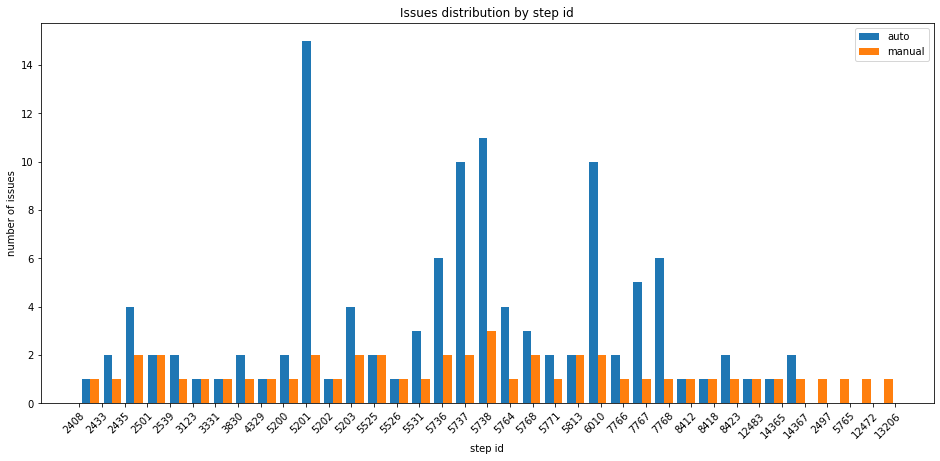

In [8]:
plt.figure(figsize=(16, 7))
plt.hist([df_auto.sort_values(by='step_id')['step_id'].map(lambda x: str(int(x))), 
    df_manual.sort_values(by='step_id')['step_id'].map(lambda x: str(int(x)))], 
         bins=steps_n, label=['auto', 'manual'])
plt.xticks(rotation=45, ha="right", rotation_mode='anchor')
plt.legend()
plt.title('Issues distribution by step id')
plt.xlabel('step id')
plt.ylabel('number of issues')
plt.show()

In [9]:
print('Frequency of issues detected automatically:')
display(df_auto['frequency'].describe())

Frequency of issues detected automatically:


count    113.000000
mean       0.738577
std        0.266728
min        0.065844
25%        0.633423
50%        0.828508
75%        0.959569
max        0.998742
Name: frequency, dtype: float64

In [10]:
print('Frequency of issues detected manually:')
display(df_manual['frequency'].describe())

Frequency of issues detected manually:


count    49.000000
mean      0.768163
std       0.204315
min       0.210000
25%       0.700000
50%       0.840000
75%       0.910000
max       1.000000
Name: frequency, dtype: float64

## Validation results

In [11]:
print('Matching by step, issue and position in template with broadcasting manually found issues:')
df_not_matched = match(df_auto, df_manual)

Matching by step, issue and position in template with broadcasting manually found issues:

    manual total cnt: 123
    auto total cnt: 113
    manual and auto found: 53
    manual only found: 70
    auto only found: 58
    (manual & auto) / (all manual): 0.43089430894308944
    (auto only found) / (all auto): 0.5132743362831859
    


In [12]:
print('Matching by step, issue class and number of such issues, numberes must be exactly equal to match:')
df_not_matched = match_numbered(df_auto, df_manual, mode='eq')

Matching by step, issue class and number of such issues, numberes must be exactly equal to match:

    manual total cnt: 49
    auto total cnt: 67
    manual and auto found: 27
    manual only found: 18
    auto only found: 40
    (manual & auto) / (all manual): 0.5510204081632653
    (auto only found) / (all auto): 0.5970149253731343
    


In [13]:
print('Matching by step, issue class and number of such issues, considering difference between numbers:')
df_not_matched = match_numbered(df_auto, df_manual, mode='diff')

Matching by step, issue class and number of such issues, considering difference between numbers:

    manual total cnt: 49
    auto total cnt: 113
    manual and auto found: 42
    manual only found: 3
    auto only found: 71
    (manual & auto) / (all manual): 0.8571428571428571
    (auto only found) / (all auto): 0.6283185840707964
    


In [14]:
print('Matching by step and issue class only:')
df_not_matched = match_sets(df_auto, df_manual)

Matching by step and issue class only:

    manual total cnt: 49
    auto total cnt: 67
    manual and auto found: 42
    manual only found: 7
    auto only found: 25
    (manual & auto) / (all manual): 0.8571428571428571
    (auto only found) / (all auto): 0.373134328358209
    
